**Importing Required Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import transformers
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score
from transformers import AdamW,DebertaTokenizer,DebertaModel

**Checking avilability of GPU**

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


**Data Loading and Data Visualization**

In [84]:
df = pd.read_csv('/kaggle/input/explainable-detection-of-online-sexism/edos_labelled_aggregated.csv')
df = df[df['label_sexist'] == "sexist"]
print(df.head)

# for task A we don't need these things
df.drop(['rewire_id','label_sexist','label_category'], axis=1, inplace=True)

<bound method NDFrame.head of                       rewire_id  \
6       sexism2022_english-7228   
8        sexism2022_english-872   
9       sexism2022_english-3553   
14     sexism2022_english-14992   
15     sexism2022_english-13328   
...                         ...   
19983  sexism2022_english-17659   
19984  sexism2022_english-13737   
19986   sexism2022_english-8065   
19992  sexism2022_english-12176   
19999   sexism2022_english-3523   

                                                    text label_sexist  \
6      [USER] Leg day is easy. Hot girls who wear min...       sexist   
8      I get a new pussy every other week or whenever...       sexist   
9      I agree with that but at the same time I know ...       sexist   
14     O come on there's no way any men are attracted...       sexist   
15     democrats from Minnesota (leftist muzzie shith...       sexist   
...                                                  ...          ...   
19983  This is easily the dumbest thin

In [85]:
dfTrain=df[df['split']=="train"]
dfVal=df[df['split']=="dev"]
dfTest=df[df['split']=="test"]
#df.drop(['rewire_id','label_category','label_vector'], axis=1, inplace=True)

In [86]:
dfTrain.drop(['split'], axis=1, inplace=True)
dfVal.drop(['split'], axis=1, inplace=True)
dfTest.drop(['split'], axis=1, inplace=True)
print(dfTrain.shape,dfVal.shape,dfTest.shape)

(3398, 2) (486, 2) (970, 2)


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [87]:
print(dfTrain.head())

                                                 text  \
6   [USER] Leg day is easy. Hot girls who wear min...   
8   I get a new pussy every other week or whenever...   
14  O come on there's no way any men are attracted...   
26  Former BBC journalist Thuto Mali says that uni...   
32  I did. You have to have the bravery to escalat...   

                                         label_vector  
6                 3.3 backhanded gendered compliments  
8   2.3 dehumanising attacks & overt sexual object...  
14  2.3 dehumanising attacks & overt sexual object...  
26  4.2 supporting systemic discrimination against...  
32           1.2 incitement and encouragement of harm  


In [89]:
freq=df['label_vector'].value_counts().to_dict()
print(freq)

{'2.1 descriptive attacks': 1024, '2.2 aggressive and emotive attacks': 961, '3.1 casual use of gendered slurs, profanities, and insults': 910, '3.2 immutable gender differences and gender stereotypes': 596, '4.2 supporting systemic discrimination against women as a group': 368, '1.2 incitement and encouragement of harm': 363, '2.3 dehumanising attacks & overt sexual objectification': 286, '4.1 supporting mistreatment of individual women': 107, '3.3 backhanded gendered compliments': 91, '1.1 threats of harm': 80, '3.4 condescending explanations or unwelcome advice': 68}


**Distibution of sexist and non sexist text labels**

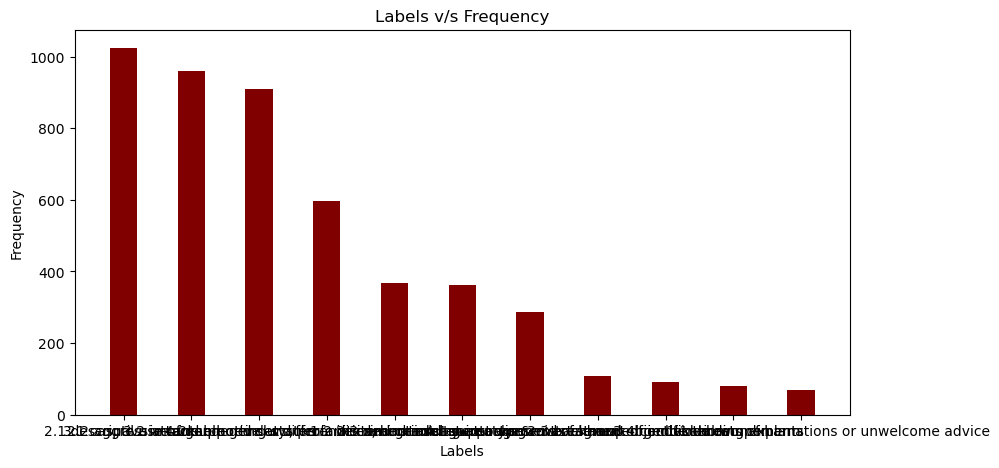

In [90]:
data = freq
types = list(data.keys())
frequency = list(data.values())

fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(types, frequency, color ='maroon',width = 0.4)
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Labels v/s Frequency")
plt.show()

**Distibution of Numbers of words in each text**

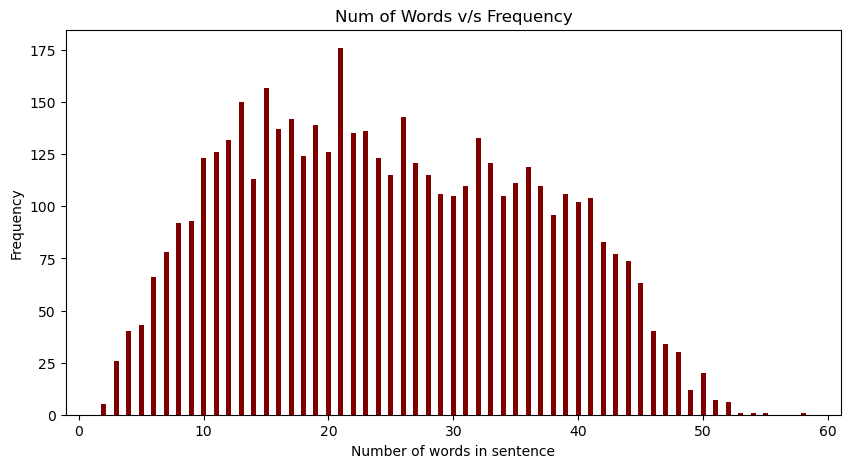

In [91]:
freq={}
texts=df['text'].tolist()
for sentence in texts:
    num_text=len(sentence.split())
    if num_text not in freq:
        freq[num_text]=0
    freq[num_text]+=1

types = list(freq.keys())
frequency = list(freq.values())

fig = plt.figure(figsize = (10, 5))
plt.bar(types, frequency, color ='maroon',width = 0.4)
plt.xlabel("Number of words in sentence")
plt.ylabel("Frequency")
plt.title("Num of Words v/s Frequency")
plt.show()

**Loading Model**

In [92]:
# DeBERTa
print('Loading Base model')
deberta = DebertaModel.from_pretrained("microsoft/deberta-base")
deberta_tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")    

Loading Base model


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Converting Train Data to Data Loader format**

In [93]:
MAX_LENGHT = 64
batch_size = 128

**DataLoader**

In [94]:
def loader(df,batch_size=128,train=True,MAX_LENGHT=64):
    """
        Given a dataframe it will return a dataloader
    """

    texts=df['text'].tolist()
    labels=df['label_vector'].tolist()
    
    tokens_deberta = deberta_tokenizer.batch_encode_plus(texts,max_length = MAX_LENGHT,pad_to_max_length=True,truncation=True)
    seq_deberta = torch.tensor(tokens_deberta['input_ids'],device=device)
    mask_deberta = torch.tensor(tokens_deberta['attention_mask'],device=device)

    
    # 1 for sexist and 0 for non sexist
    y=[]
    for label in labels:
        if label=="1.1 threats of harm":
            y.append(0)
        elif label=="1.2 incitement and encouragement of harm":
            y.append(1)
        elif label=="2.1 descriptive attacks":
            y.append(2)
        elif label=="2.2 aggressive and emotive attacks":
            y.append(3)
        elif label=="2.3 dehumanising attacks & overt sexual objectification":
            y.append(4)
        elif label=="3.1 casual use of gendered slurs, profanities, and insults":
            y.append(5)
        elif label=="3.2 immutable gender differences and gender stereotypes":
            y.append(6)
        elif label=="3.3 backhanded gendered compliments":
            y.append(7)
        elif label=="3.4 condescending explanations or unwelcome advice":
            y.append(8)
        elif label=="4.1 supporting mistreatment of individual women":
            y.append(9)
        else: #4.2 supporting systemic discrimination against women as a group
            y.append(10)
            
    y = torch.tensor(y,device=device)
    
    data = TensorDataset(seq_deberta, mask_deberta, y)    
  
    if train:
        dataloader = DataLoader(data, shuffle=True, batch_size=batch_size)
    else:
        dataloader = DataLoader(data,batch_size=batch_size,shuffle=False)

    return dataloader

In [95]:
trainDataLoader=loader(dfTrain,batch_size=128,train=True)
valDataLoader= loader(dfVal,batch_size=128,train=False)
testDataLoader= loader(dfTest,batch_size=128,train=False)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2345: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


**Weights of Roberta Will change**

In [96]:
for param in deberta.parameters():
    param.requires_grad = True  

**Model**

In [97]:
class DeBERT_Arch(nn.Module):
    def __init__(self, deberta):  
        super(DeBERT_Arch, self).__init__()
        self.deberta = deberta
        self.dropout = nn.Dropout(0.1)            
        self.relu =  nn.ReLU()                    
        
        self.fc0 = nn.Linear(768,512)           
        self.fc1 = nn.Linear(512,256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,11)  
        
        self.softmax = nn.LogSoftmax(dim=1)       
    
    def forward(self, sent_id_deberta, mask_deberta):            
        
        cls_hs = self.deberta(sent_id_deberta, attention_mask=mask_deberta)

        hidden_state = cls_hs[0]
        cls_hs = hidden_state[:, 0]
        
        x = self.fc0(cls_hs)
        x = self.relu(x)    
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x) #Activation function,followed by dropout , in case of relu it is same
        x = self.dropout(x)
        x = self.fc2(x)    
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.softmax(x)      
        return x

model = DeBERT_Arch(deberta)
model= nn.DataParallel(model)#for two gpu, divide the batch size into two half and work
model = model.to(device)

**Hyperparameter**

In [98]:
optimizer = AdamW(model.parameters(),lr = 1e-5)         
cross_entropy  = nn.NLLLoss() 
epochs = 20

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


**Training**

In [99]:
def train(train_dataloader,val_dataloader,useFullData=False):  
    model.train()
    total_loss=0
    dataloader=[train_dataloader]
    
    if useFullData:
        dataloader=[val_dataloader]
  
    for loader in dataloader:
        for step,batch in enumerate(tqdm(loader,position=0, leave=True)):                                  
            sent_id_deberta, mask_deberta,labels = batch 
            model.zero_grad()                                          
            preds = model(sent_id_deberta, mask_deberta)           
        
            loss = cross_entropy(preds, labels)   
        
            loss.backward()                                             
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     
            optimizer.step()    
            total_loss = total_loss + loss.item()                    
    
    # checking validation accuracy
    if useFullData==False:
        model.eval()
        with torch.no_grad():
            val_preds=[]
            actual=[]
            for step,batch in enumerate(tqdm(val_dataloader,position=0, leave=True)):          
                                         
                sent_id_deberta, mask_deberta, labels = batch 
            
                preds = model(sent_id_deberta, mask_deberta)          
                preds = torch.argmax(preds,dim=1)
                val_preds+=preds.tolist()                         
                actual+=labels.tolist()
                
            valf1=f1_score(val_preds,actual,average="macro")
        return total_loss,valf1
    return total_loss,None # in this we are training on validation to get final model
    # so no use of testing on validation data itself

**Taining of Train Data**

In [100]:
counter=1
lossT=[]
val_f1=[]
for epoch in range(epochs):     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))     
    total_loss,f1 = train(trainDataLoader,valDataLoader)            
    lossT.append(total_loss)
    val_f1.append(f1)
    print('Training Loss: ',total_loss)
    print("Validation F1 score: ",f1)
    torch.save(model.state_dict(), 'DebertaC'+str(counter)+".pt")
    counter+=1


 Epoch 1 / 20


100%|██████████| 4/4 [00:01<00:00,  3.19it/s]


Training Loss:  64.43018960952759
Validation F1 score:  0.02999062792877226

 Epoch 2 / 20


100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


Training Loss:  62.05736303329468
Validation F1 score:  0.03153988868274582

 Epoch 3 / 20


100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


Training Loss:  59.47384238243103
Validation F1 score:  0.03153988868274582

 Epoch 4 / 20


100%|██████████| 4/4 [00:01<00:00,  3.31it/s]


Training Loss:  57.53522992134094
Validation F1 score:  0.07705303974518764

 Epoch 5 / 20


100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


Training Loss:  55.46260952949524
Validation F1 score:  0.07775349650349649

 Epoch 6 / 20


100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


Training Loss:  53.43980073928833
Validation F1 score:  0.08357742415818796

 Epoch 7 / 20


100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


Training Loss:  51.37425637245178
Validation F1 score:  0.08128673494527153

 Epoch 8 / 20


100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


Training Loss:  48.893927812576294
Validation F1 score:  0.13745397768872497

 Epoch 9 / 20


100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


Training Loss:  46.642696380615234
Validation F1 score:  0.13594638341273368

 Epoch 10 / 20


100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


Training Loss:  44.85618543624878
Validation F1 score:  0.15490320676120747

 Epoch 11 / 20


100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


Training Loss:  42.56008791923523
Validation F1 score:  0.17590649730741545

 Epoch 12 / 20


100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


Training Loss:  40.65346324443817
Validation F1 score:  0.21876893967707323

 Epoch 13 / 20


100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


Training Loss:  38.739460706710815
Validation F1 score:  0.2515880470464366

 Epoch 14 / 20


100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


Training Loss:  36.89563262462616
Validation F1 score:  0.27170324641762655

 Epoch 15 / 20


100%|██████████| 4/4 [00:01<00:00,  3.31it/s]


Training Loss:  35.382604479789734
Validation F1 score:  0.2669458441704052

 Epoch 16 / 20


100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


Training Loss:  33.59861624240875
Validation F1 score:  0.27578044986269185

 Epoch 17 / 20


100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


Training Loss:  31.827071130275726
Validation F1 score:  0.2892163374371085

 Epoch 18 / 20


100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


Training Loss:  30.385074257850647
Validation F1 score:  0.29594145709037095

 Epoch 19 / 20


100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


Training Loss:  29.226646423339844
Validation F1 score:  0.2985234922432931

 Epoch 20 / 20


100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


Training Loss:  27.429755210876465
Validation F1 score:  0.2874038773019854


**Plotting Training Loss and Validation Macro F1 score**

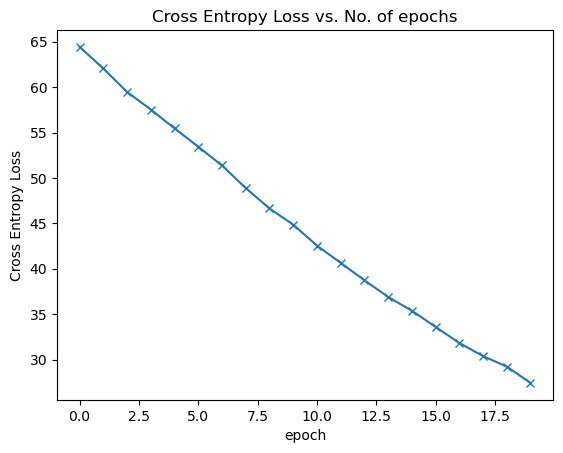

In [103]:
def plot_losses(losses):
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('Cross Entropy Loss')
    plt.title('Cross Entropy Loss vs. No. of epochs')
    
plot_losses(lossT)

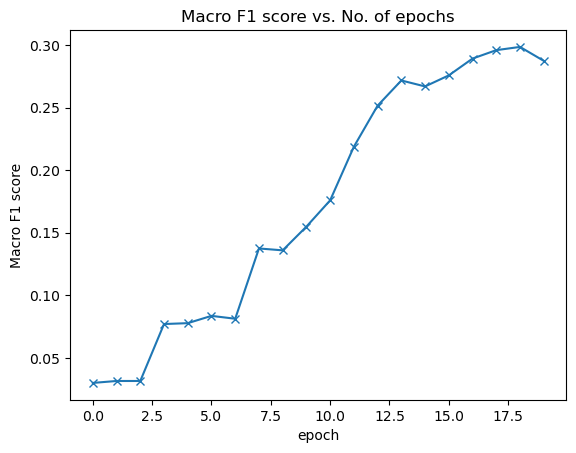

In [104]:
def plot_score(f1):
    plt.plot(f1, '-x')
    plt.xlabel('epoch')
    plt.ylabel('Macro F1 score')
    plt.title('Macro F1 score vs. No. of epochs')
    
plot_score(val_f1)

**Load Model:** Loading the model with good Macro F1 score and then using validation data as well to train over it

In [105]:
path = "/kaggle/working/DebertaC19.pt"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [106]:
counter=1
for epoch in range(epochs):     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))     
    _L,_ = train(trainDataLoader,valDataLoader,True)


 Epoch 1 / 20


100%|██████████| 4/4 [00:03<00:00,  1.12it/s]



 Epoch 2 / 20


100%|██████████| 4/4 [00:03<00:00,  1.13it/s]



 Epoch 3 / 20


100%|██████████| 4/4 [00:03<00:00,  1.11it/s]



 Epoch 4 / 20


100%|██████████| 4/4 [00:03<00:00,  1.10it/s]



 Epoch 5 / 20


100%|██████████| 4/4 [00:03<00:00,  1.09it/s]



 Epoch 6 / 20


100%|██████████| 4/4 [00:03<00:00,  1.10it/s]



 Epoch 7 / 20


100%|██████████| 4/4 [00:03<00:00,  1.12it/s]



 Epoch 8 / 20


100%|██████████| 4/4 [00:03<00:00,  1.13it/s]



 Epoch 9 / 20


100%|██████████| 4/4 [00:03<00:00,  1.14it/s]



 Epoch 10 / 20


100%|██████████| 4/4 [00:03<00:00,  1.15it/s]



 Epoch 11 / 20


100%|██████████| 4/4 [00:03<00:00,  1.16it/s]



 Epoch 12 / 20


100%|██████████| 4/4 [00:03<00:00,  1.16it/s]



 Epoch 13 / 20


100%|██████████| 4/4 [00:03<00:00,  1.17it/s]



 Epoch 14 / 20


100%|██████████| 4/4 [00:03<00:00,  1.10it/s]



 Epoch 15 / 20


100%|██████████| 4/4 [00:03<00:00,  1.17it/s]



 Epoch 16 / 20


100%|██████████| 4/4 [00:03<00:00,  1.17it/s]



 Epoch 17 / 20


100%|██████████| 4/4 [00:03<00:00,  1.17it/s]



 Epoch 18 / 20


100%|██████████| 4/4 [00:03<00:00,  1.17it/s]



 Epoch 19 / 20


100%|██████████| 4/4 [00:03<00:00,  1.17it/s]



 Epoch 20 / 20


100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


**F1 score for Test Data**

In [107]:
#checking test accuracy    
def testAccuracy(test_dataloader,model):
    model.eval()
    with torch.no_grad():
        test_preds=[]
        actual=[]
        for step,batch in enumerate(tqdm(test_dataloader,position=0, leave=True)):          
                                             
            sent_id_roberta, mask_roberta, labels = batch 
            
            preds = model(sent_id_roberta, mask_roberta)          
            preds = torch.argmax(preds,dim=1)
            test_preds+=preds.tolist()                         
            actual+=labels.tolist()
        testf1=f1_score(test_preds,actual,average="macro")
    
    return testf1

In [108]:
testf1=testAccuracy(testDataLoader,model)
print("Test Accuracy is: ",testf1)

100%|██████████| 8/8 [00:02<00:00,  3.38it/s]

Test Accuracy is:  0.300903858774195


In [111]:
def Inference(testTexts):
    """
        Takes a list of texts
        No backpropogation. Better way to do this, is with dataloader
    """
    
    tokens_test_deberta = deberta_tokenizer.batch_encode_plus(testTexts,max_length = MAX_LENGHT,pad_to_max_length=True,truncation=True)
    test_seq_deberta = torch.tensor(tokens_test_deberta['input_ids'],device=device)
    test_mask_deberta = torch.tensor(tokens_test_deberta['attention_mask'],device=device)
    
    model.eval()
    with torch.no_grad():
        preds = model(test_seq_deberta, test_mask_deberta)
        preds = preds.detach().cpu().numpy()
    
    preds = np.argmax(preds, axis = 1)
    
    label_pred=[]

    for label in preds:
        if label == 0:
            label_pred.append('1.1 threats of harm')
        elif label == 1:
            label_pred.append('1.2 incitement and encouragement of harm')
        elif label == 2:
            label_pred.append('2.1 descriptive attacks')
        elif label == 3:
            label_pred.append('2.2 aggressive and emotive attacks')
        elif label == 4:
            label_pred.append('2.3 dehumanising attacks & overt sexual objectification')
        elif label == 5:
            label_pred.append('3.1 casual use of gendered slurs, profanities, and insults')
        elif label == 6:
            label_pred.append('3.2 immutable gender differences and gender stereotypes')
        elif label == 7:
            label_pred.append('3.3 backhanded gendered compliments')
        elif label == 8:
            label_pred.append('3.4 condescending explanations or unwelcome advice')
        elif label == 9:
            label_pred.append('4.1 supporting mistreatment of individual women')
        else:
            label_pred.append('4.2 supporting systemic discrimination against women as a group')
    
    
    return "The text is "+label_pred[0]

In [112]:
data=["Hey, Have a good day ahead"] # we need to give sexist tweet here, this is not sexist
Inference(data)

'The text is 3.1 casual use of gendered slurs, profanities, and insults'